[Titanic: Machine Learning from Disaster | Kaggle](https://www.kaggle.com/c/titanic)

In [15]:
#グラフをnotebook内に描画させるための設定
%matplotlib inline 

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df_data = pd.read_csv("./train.csv")

In [39]:
age_list = df_data.pivot_table(values='Age', index='Pclass', columns=['Sex'])
    
def preprocess(df, age_list = age_list):
    df_en = df
    
    # Sexは0,1で表現する。
    sex_mapping = {'female': 0, 'male': 1}
    df_en['is_male'] = df_en['Sex'].map(sex_mapping)

    # ageの欠損値を埋める。
    # temp = df.pivot_table(values='Age', index='Pclass', columns=['Sex'])
    df_en['age'] = [age_list.loc[df_en.loc[i, 'Pclass'], df_en.loc[i, 'Sex']] if math.isnan(x)  else x for i, x in df_en['Age'].iteritems()]
    
    # Cabinは有無を表す２値に変更
    df_en['has_cabin'] = (df_en['Cabin'].notnull() == True).astype(int)
    df_en = df_en.drop(columns=['Cabin'])
    
    # EmbarkedはOneHotEncoding
    df_en = pd.concat([df_en, pd.get_dummies(df_en['Embarked'], prefix='embarked')], axis=1)
    
    return df_en.drop(columns=['Sex', 'Ticket', 'Name', 'Embarked', 'Age'])

In [40]:
# とりあえず普通にランダムフォレスト使ってみる。
# overfitしているのがわかる。

kf = KFold(n_splits=5, random_state=117)
models = []

df_en = preprocess(df_data)
for train_index, test_index in kf.split(df_en):
    clf = RandomForestClassifier()
    models.append(clf)
    X           = df_en.drop(columns=['PassengerId', 'Survived']).iloc[train_index].values
    X_test = df_en.drop(columns=['PassengerId', 'Survived']).iloc[test_index].values
    y           = df_en['Survived'].iloc[train_index].values
    y_test = df_en['Survived'].iloc[test_index].values

    clf.fit(X, y)
    
    print('score original:{0:.3f} test:{1:.3f}'.format(clf.score(X, y), clf.score(X_test, y_test)))


score original:0.966 test:0.771
score original:0.980 test:0.809
score original:0.969 test:0.826
score original:0.975 test:0.730
score original:0.972 test:0.820


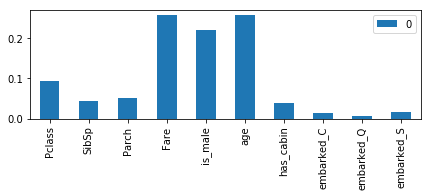

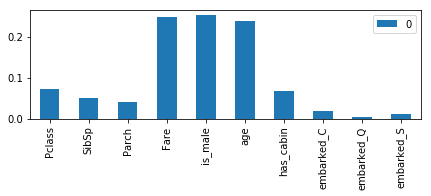

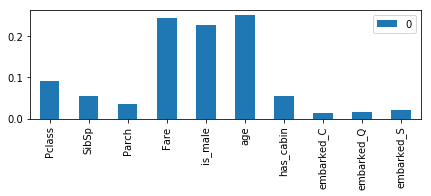

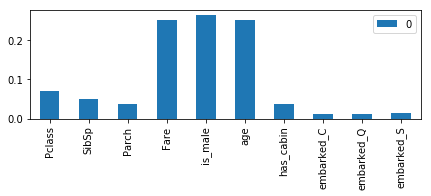

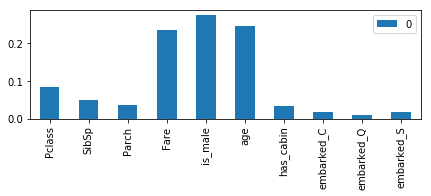

In [26]:
for clf in models:
    pd.DataFrame(clf.feature_importances_, index=df_en.drop(columns=['PassengerId', 'Survived']).columns).plot.bar(figsize=(7,2))

In [41]:
model = RandomForestClassifier()
parameters = {
    'n_estimators'      : [5, 10, 20, 40],
    'max_features'      : [3, 5, 7, 10],
    'min_samples_split' : [2, 3, 5],
    'max_depth'         : [3, 5, 10],
}
clf = GridSearchCV(model, parameters, cv=5)
clf.fit(df_en.drop(columns=['PassengerId', 'Survived']).values, df_en['Survived'].values)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20, 40], 'max_features': [3, 5, 7, 10], 'min_samples_split': [2, 3, 5], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [84]:
display(clf.best_estimator_)
display(clf.best_score_)
display(clf.best_params_)
display(clf.best_index_)
display(clf.n_splits_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

0.8338945005611672

{'max_depth': 10,
 'max_features': 3,
 'min_samples_split': 2,
 'n_estimators': 40}

99

5

In [85]:
df_test = pd.read_csv("./test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [86]:
df_test_en = preprocess(df_test)
df_test_en.isnull().sum()

PassengerId    0
Pclass         0
SibSp          0
Parch          0
Fare           1
is_male        0
age            0
has_cabin      0
embarked_C     0
embarked_Q     0
embarked_S     0
dtype: int64

In [87]:
df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_male,age,has_cabin
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,60.5,0


In [88]:
display(df_data[df_data['Ticket'] == '3701'])
display(df_data[df_data['Ticket'].str.startswith('370')])
display(df_test[df_test['Ticket'] == '3701'])
display(df_test[df_test['Ticket'].str.startswith('370')])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_male,age,has_cabin


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_male,age,has_cabin
46,47,0,3,"Lennon, Mr. Denis",male,NaN,1,0,370371,15.5000,NaN,Q,1,26.507589,0
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,1,70.500000,0
126,127,0,3,"McMahon, Mr. Martin",male,NaN,0,0,370372,7.7500,NaN,Q,1,26.507589,0
186,187,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,0,21.750000,0
198,199,1,3,"Madigan, Miss. Margaret ""Maggie""",female,NaN,0,0,370370,7.7500,NaN,Q,0,21.750000,0
254,255,0,3,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",female,41.0,0,2,370129,20.2125,NaN,S,0,41.000000,0
274,275,1,3,"Healy, Miss. Hanora ""Nora""",female,NaN,0,0,370375,7.7500,NaN,Q,0,21.750000,0
289,290,1,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q,0,22.000000,0
364,365,0,3,"O'Brien, Mr. Thomas",male,NaN,1,0,370365,15.5000,NaN,Q,1,26.507589,0
424,425,0,3,"Rosblom, Mr. Viktor Richard",male,18.0,1,1,370129,20.2125,NaN,S,1,18.000000,0


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_male,age,has_cabin
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,60.5,0


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_male,age,has_cabin
47,939,3,"Shaughnessy, Mr. Patrick",male,NaN,0,0,370374,7.7500,NaN,Q,1,26.507589,0
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,60.500000,0
227,1119,3,"McNeill, Miss. Bridget",female,NaN,0,0,370368,7.7500,NaN,Q,0,21.750000,0
273,1165,3,"Lennon, Miss. Mary",female,NaN,1,0,370371,15.5000,NaN,Q,0,21.750000,0
284,1176,3,"Rosblom, Miss. Salli Helena",female,2.0,1,1,370129,20.2125,NaN,S,0,2.000000,0


In [89]:
fare_mean = df_data[(df_data['Pclass'] == 3) & (df_data['Embarked'] == 'S') & (df_data['Cabin'].isnull())]['Fare'].mean()
display(fare_mean)

14.749522740524794

In [90]:
df_test_en = df_test_en.fillna({'Fare': fare_mean})

In [91]:
y_pred = clf.best_estimator_.predict(df_test_en.drop(columns=['PassengerId']).values)

In [92]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_male,age,has_cabin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,34.5,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,47.0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,62.0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1,27.0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,22.0,0


In [81]:
df_result = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})
display(df_result.head())

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [82]:
df_result.to_csv("result180409.csv", index=False)